In [30]:
import os

# Set HTTP proxy
os.environ['HTTP_PROXY'] = '127.0.0.1:7890'

# Set HTTPS proxy
os.environ['HTTPS_PROXY'] = '127.0.0.1:7890'

In [31]:
import ee
import pandas as pd
import numpy as np
from dfply import *


import matplotlib.pyplot as plt
import seaborn as sns
import scipy

import plotnine
from plotnine import *

import itertools
import difflib
import sys
import os
import requests
from tqdm.auto import tqdm
from pprint import pprint

In [32]:
# authenticate earthengine api
ee.Initialize()

In [33]:
from Modules.Modules import filter_exclude, get_img_df, compute_mean_ci
from Modules.Parallize_df import parallelize_dataframe

# might need reload modules as the code progrocessing
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
# get the admin shp
NCP_provinces = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_province_boundry")

# get the GAEZ pixel size
GAEZ_pix_scale = ee.Image("users/wangjinzhulala/Paper_3/03_GAEZ/GAEZ_2_Moisture_Annual_P_PET_1981_2010_Historical").projection().nominalScale().getInfo()

In [35]:
# read data
crop_yield_history_1975_2020 = pd.read_csv('./result_csv/crop_yield_history_1975_2020.csv')
GYGA_weighted_by_area_ratio = pd.read_csv('./result_csv/GYGA_weighted_by_area_ratio.csv')

GAEZ_attainable_t_ha_forced_with_GYGA = pd.read_pickle('./result_csv/GAEZ_attainable_t_ha_forced_with_GYGA.pkl') 
GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul = pd.read_csv('./result_csv/GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul.csv') >> mask(X.year>=1990)
GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul['rcp'] = GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul['rcp'].astype('str')

GAEZ_actual_yield_propogated = pd.read_pickle('./result_csv/GAEZ_actual_yield_propogated.pkl')
GAEZ_actual_yield_propogated_area_weighted_mean_df = pd.read_csv('./result_csv/GAEZ_actual_yield_propogated_area_weighted_mean_df.csv')

GAEZ_actual_link_Yearbook_trend = pd.read_pickle('./result_csv/GAEZ_actual_forced_with_Yearbook.pkl')
GAEZ_actual_forced_with_Yearbook_area_weighted_mean_df = pd.read_csv('./result_csv/GAEZ_actual_forced_with_Yearbook_area_weighted_mean_df.csv')
GAEZ_actual_forced_with_Yearbook_area_weighted_mean_df['rcp'] = GAEZ_actual_forced_with_Yearbook_area_weighted_mean_df['rcp'].astype('str')

yearbook_regression_parameter_df_1990 = pd.read_csv('./result_csv/yearbook_regression_parameter_df_1990.csv') >> mask(X.start_year == 1990)
yearbook_regression_parameter_df_1990['crop'] = yearbook_regression_parameter_df_1990['crop'].astype('str')

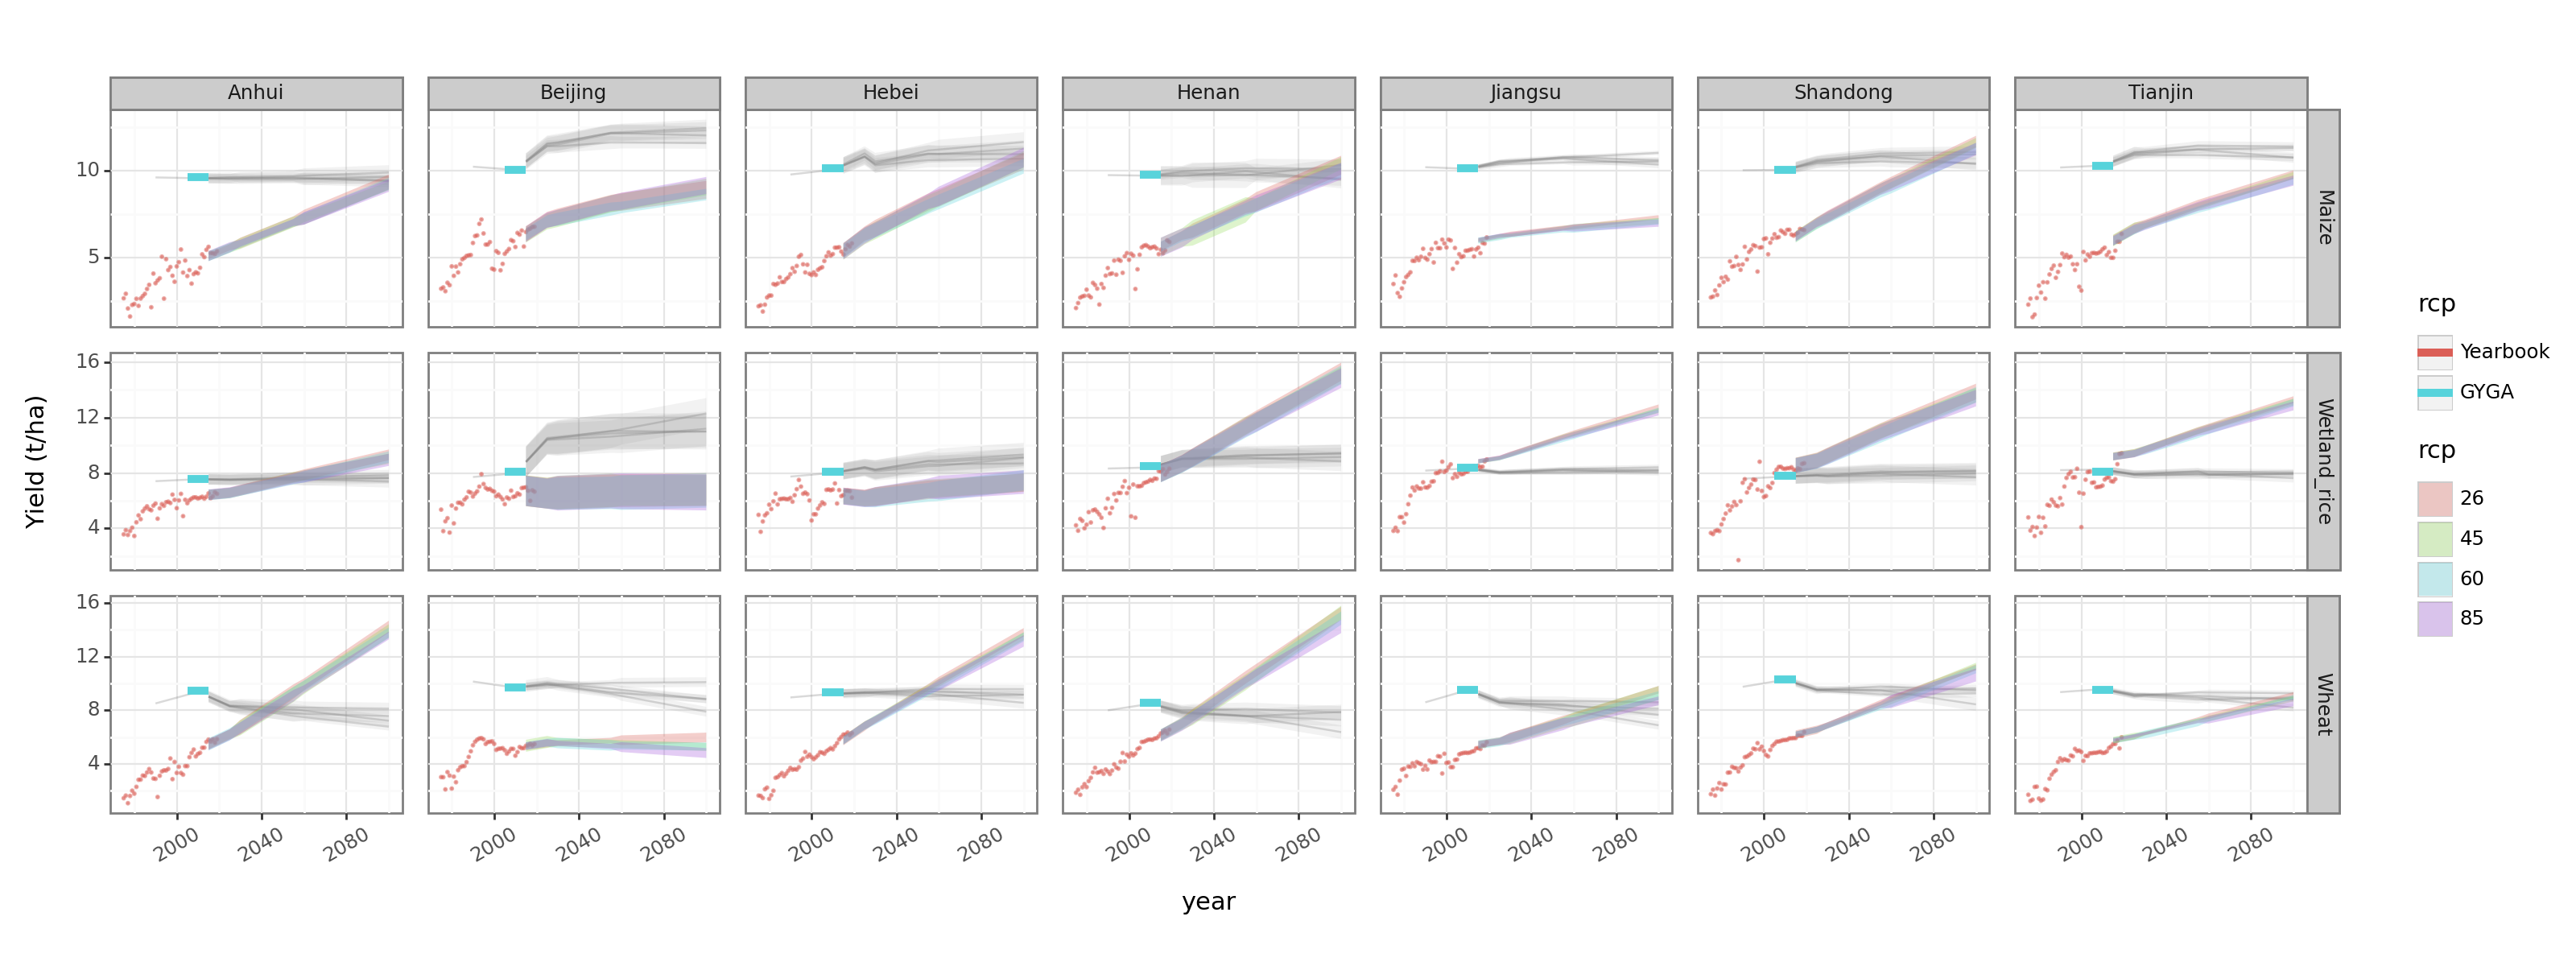

<Figure Size: (1600 x 600)>

In [36]:
# plot the trend of yearbook_yield_subtract_climate_impact
plotnine.options.figure_size = (16, 6)
plotnine.options.dpi = 100

(ggplot() +
 geom_line(GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul, aes('year','Mean Production',group='rcp'),alpha=0.3,color='grey') +
 geom_ribbon(GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul, aes(x='year',ymax='top',ymin='bot',group='rcp'),alpha=0.1,fill='grey') +
 geom_point(crop_yield_history_1975_2020, aes('year','Mean Production',color='rcp'),alpha=0.5,size=0.2) +
 geom_line(GYGA_weighted_by_area_ratio, aes('year','Mean Production',color='rcp'),size=2) +
 geom_ribbon(GAEZ_actual_forced_with_Yearbook_area_weighted_mean_df, aes(x='year',ymax='top',ymin='bot',fill='rcp',group='rcp'),alpha=0.3) +
 facet_grid('crop~Province',scales='free') +
 theme_bw() + 
 theme(axis_text_x=element_text(rotation=30)) +
 ylab('Yield (t/ha)')
)

### Scenario-1: the Business As Usual (BAU)

#### Get the year where the BAU happens

In [37]:
def get_yield_year(row):
  crop = row['crop']
  province = row['Province']
  rcp = row['rcp']
  year = row['year']

  # get the data
  min_yield = min(row['Mean Production_x'],row['Mean Production_y'])
  img_source = 'Actual' if min_yield == row['Mean Production_x'] else 'Attainable'

  return min_yield,img_source

In [38]:
# drop duplicated columns
Pred_actual = GAEZ_actual_forced_with_Yearbook_area_weighted_mean_df >> drop(['sd','top','bot'])
Pred_attainable = GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul >> drop(['top','bot'])

# merge two dfs
Pred_merge = Pred_actual.merge(Pred_attainable,on=['Province','crop','year','rcp'])
Pred_merge[['Mean Production','Source']] = Pred_merge.apply(lambda row:get_yield_year(row),1).tolist()

# compute the bot/top
Pred_merge['bot'] = Pred_merge.apply(lambda row:row['Mean Production'] - row['sd'],1)
Pred_merge['top'] = Pred_merge.apply(lambda row:row['Mean Production'] + row['sd'],1)

# remove unecessary columns
Pred_merge = Pred_merge >> drop(['Mean Production_x','Mean Production_y'])

In [39]:
# rename Wetland_rice to Rice for easier plotting
Pred_merge_plot = Pred_merge.replace({'Wetland_rice':'Rice'})
crop_yield_history_1975_2020_plot = crop_yield_history_1975_2020.replace({'Wetland_rice':'Rice'})

C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\themes\themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


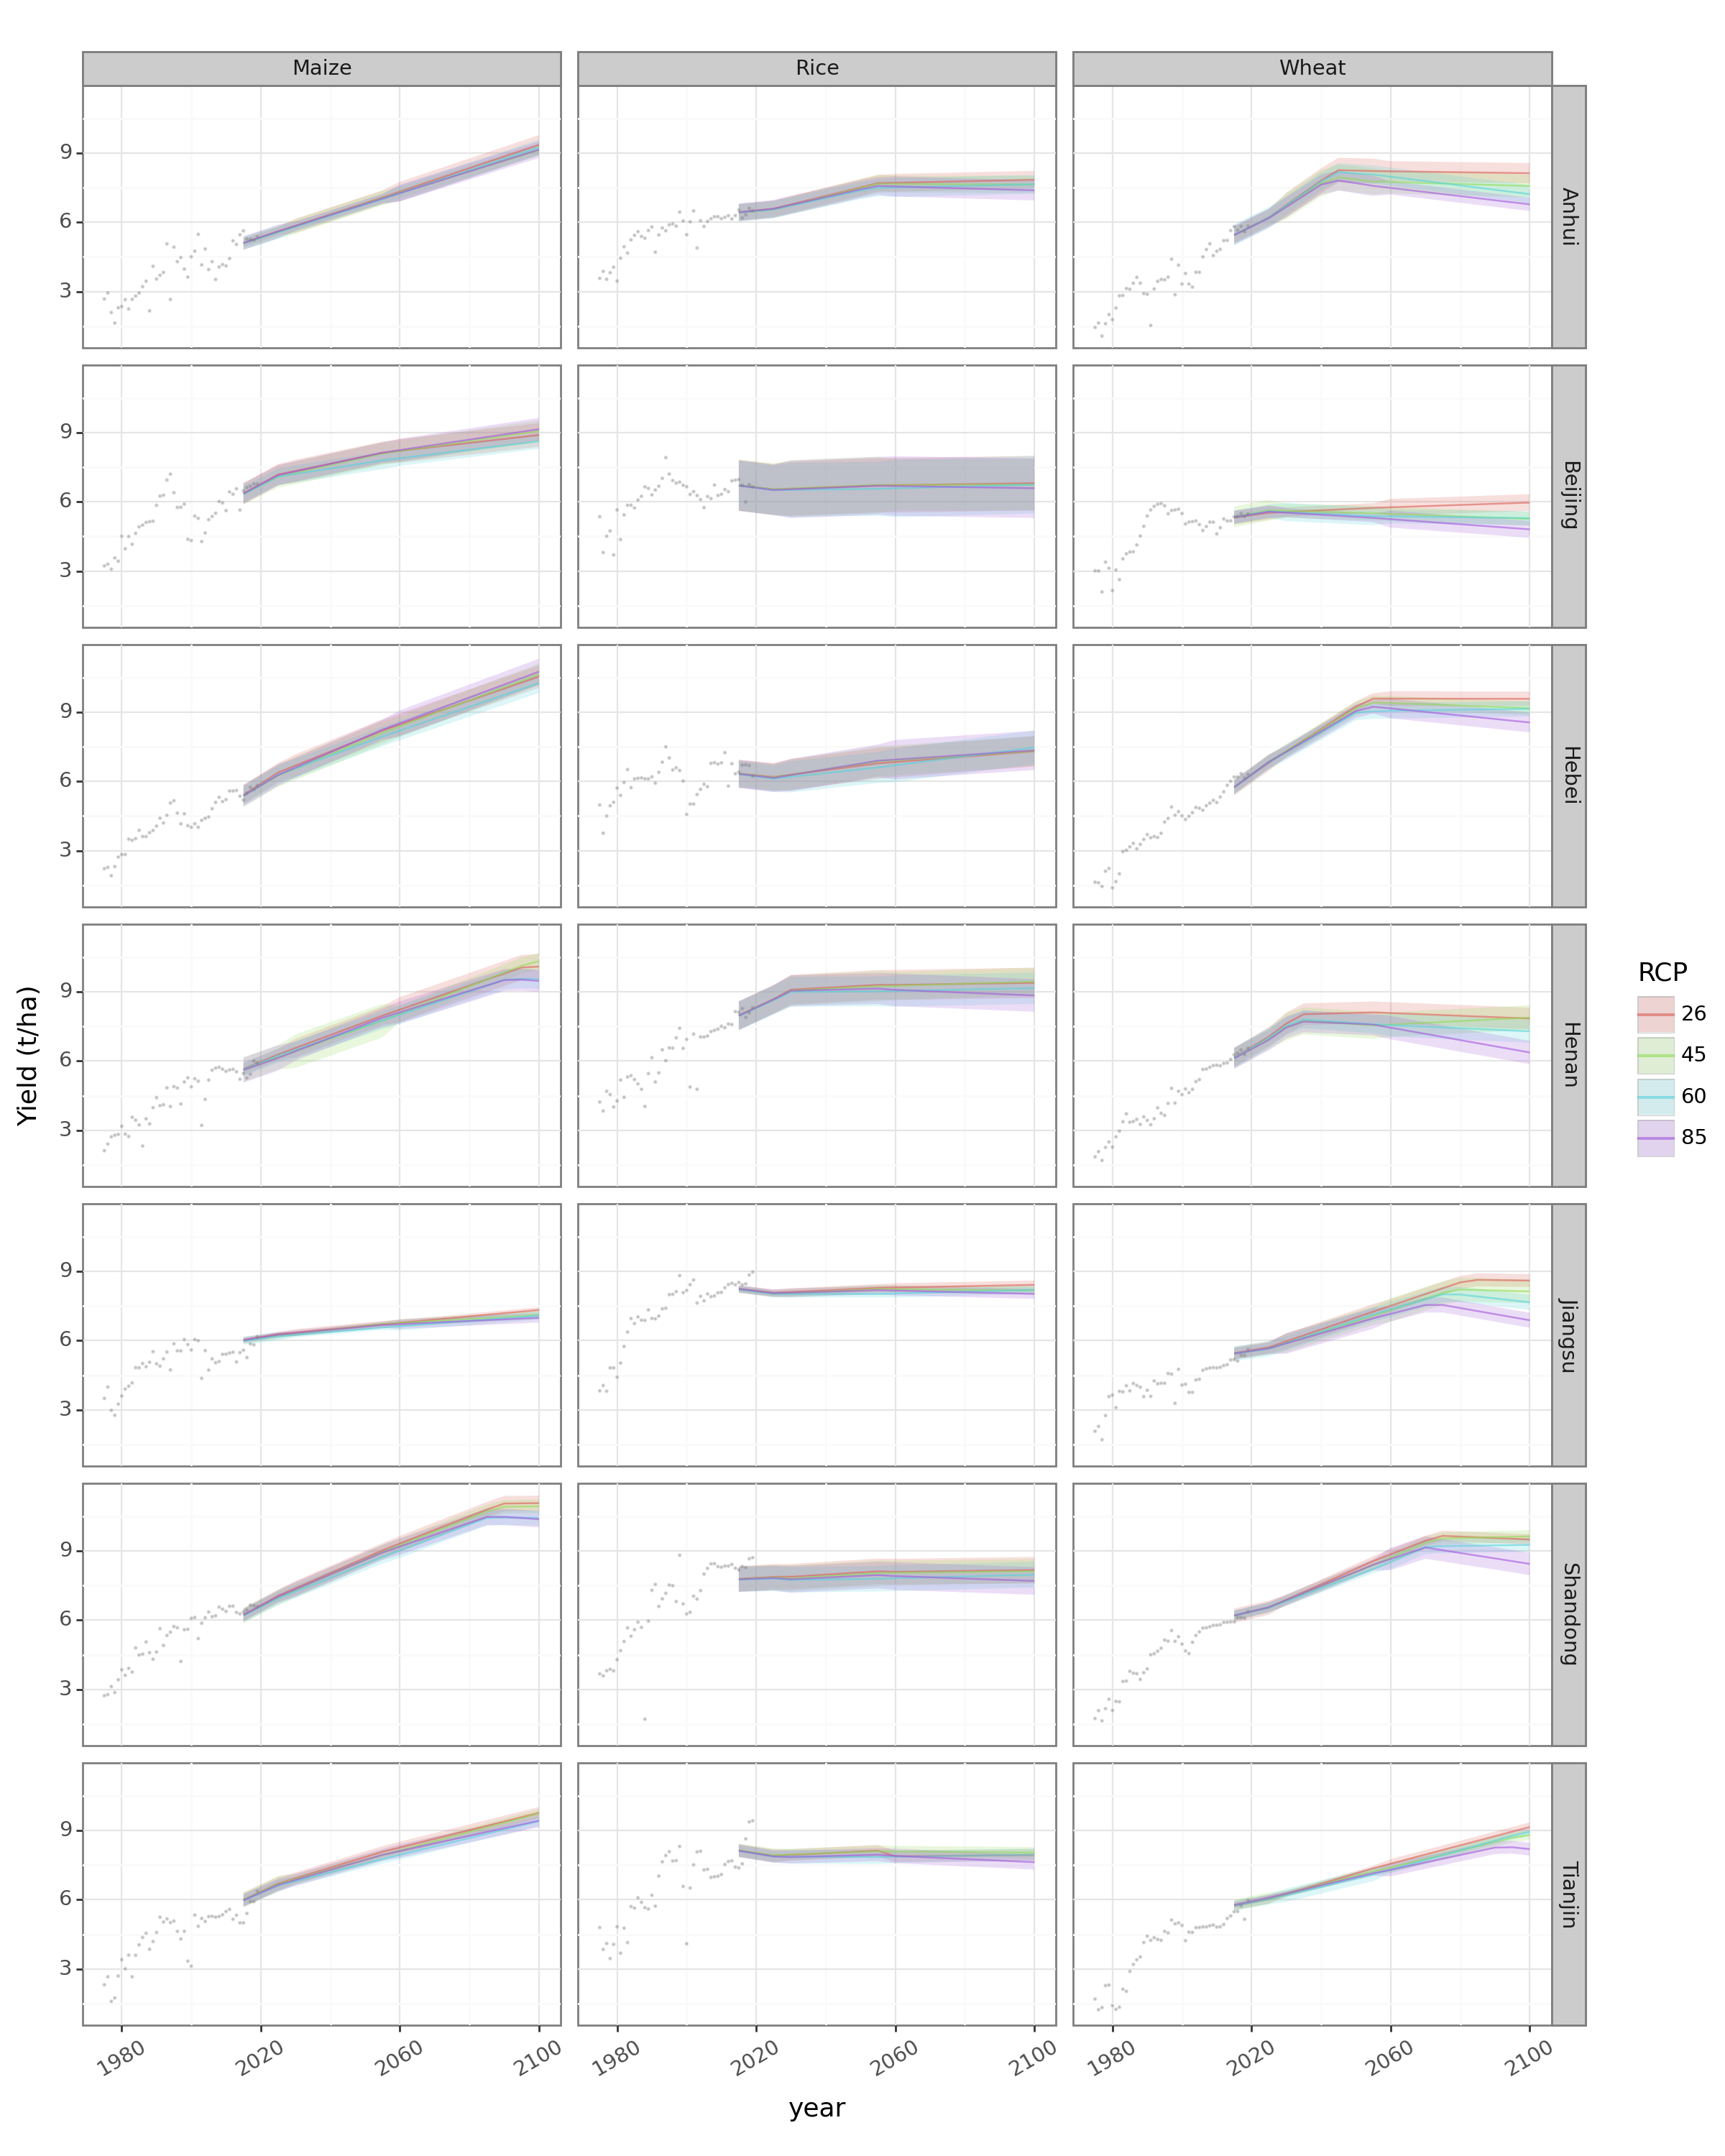

<Figure Size: (1200 x 1500)>

In [40]:
# plot the trend of yearbook_yield_subtract_climate_impact
plotnine.options.figure_size = (12, 15)
plotnine.options.dpi = 100


g = (ggplot() +
 geom_ribbon(Pred_merge_plot, aes(x='year',ymax='top',ymin='bot',fill='rcp'),alpha=0.2) +
 geom_line(Pred_merge_plot, aes(x='year',y='Mean Production',color='rcp'),alpha=0.6) +
 geom_point(crop_yield_history_1975_2020_plot,aes('year','Mean Production'),color='grey',alpha=0.3,size=0.1) + 

 # change legend name
 scale_fill_discrete(name='RCP') +
 scale_color_discrete(name='RCP') +
        
 facet_grid('Province~crop') +
 theme_bw(base_size=13) + 
 theme(axis_text_x=element_text(rotation=30),subplots_adjust={'wspace': 0.12}) +
 scale_x_continuous(breaks=range(1980,2101,40)) +
 ylab('Yield (t/ha)')
)

# shwo fig
g

In [ ]:
g.save('../Figs/result_1_pred_yield.svg')

#### Get the GEE_imgs according the above ['Source'] column

In [42]:
province_names = Pred_merge['Province'].unique()

# function to clip the img with the boundary of each province
def img_clip_by_shp(img):
  imgs_cliped = []
  for province in province_names:
    shp = NCP_provinces.filterMetadata('EN_Name','equals',province)
    img_cliped = img.clip(shp.geometry())
    imgs_cliped.append(img_cliped)

  return imgs_cliped

# function to ruturn the correct img given 'Source'
def get_img_given_source(row):
  source = row['Source']
  img = row['img_future_actual_cliped'] if source == 'Actual' else row['img_future_attainable_cliped']
  return img

In [43]:
# drop duplicated columns
Pred_actual_imgs = GAEZ_actual_link_Yearbook_trend >> drop(['img_future_sd'])
Pred_attainable_imgs = GAEZ_attainable_t_ha_forced_with_GYGA 

# merge two dfs
Pred_merge_imgs = Pred_actual_imgs.merge(Pred_attainable_imgs,on=['crop','water','year','rcp'])
Pred_merge_imgs = Pred_merge_imgs >> rename(img_future_actual='img_future_yield',img_future_attainable='image_mul')

# clip out each province with the NCP_provinces
Pred_merge_imgs['img_future_actual_cliped'] = Pred_merge_imgs['img_future_actual'].apply(lambda x:img_clip_by_shp(x),1)
Pred_merge_imgs['img_future_attainable_cliped'] = Pred_merge_imgs['img_future_attainable'].apply(lambda x:img_clip_by_shp(x),1)
Pred_merge_imgs['Province'] = [province_names.tolist()] * len(Pred_merge_imgs)

# explode to get full df
Pred_merge_imgs = Pred_merge_imgs.explode(['img_future_actual_cliped','img_future_attainable_cliped','Province']) \
            >> drop(['img_future_attainable','img_future_actual'])

# find the correct img
Pred_merge_imgs = Pred_merge_imgs.merge(Pred_merge)
Pred_merge_imgs['img_future'] = Pred_merge_imgs.apply(lambda x:get_img_given_source(x),1)

# remove unnecessary columsn
Pred_merge_imgs = Pred_merge_imgs >> select(['crop','water','year','rcp','Province','img_future','img_future_sd'])

In [44]:
stats_dfs = []

# loop throught ['crop','water','year','rcp'] to get imgs
# then mosaic the imgs to a single img
for idx,df in Pred_merge_imgs.groupby(['crop','water','year','rcp']):
  crop,water,year,rcp = idx
  imgs = df['img_future'].tolist()
  stats_dict = {'crop':[crop],
           'water':[water],
           'year':[year],
           'rcp':[rcp],
           'img_future':[ee.ImageCollection(imgs).mosaic()]}

  stats_df = pd.DataFrame(stats_dict)
  stats_dfs.append(stats_df)

# concat all df into a single df
Scenario_BAU_yield_img = pd.concat(stats_dfs,ignore_index=True).merge(GAEZ_attainable_t_ha_forced_with_GYGA) >> drop(['image'])
Scenario_BAU_yield_img.to_pickle('./result_csv/Scenario_BAU_yield_img.pkl')

In [45]:
def compute_area_weighted_mean(df):

  ##################### Multiply each crop_water with its area_ratio #############
  # read the harvested area ratio so we can compute the weigted mean attainable yield
  area_ratio = pd.read_pickle('./result_csv/harvested_area_ratio.pkl')
  df = df.merge(area_ratio,on=['crop','water'])

  # compute the area_weighted actual yield
  df['val_area_weighted'] = df.apply(lambda x:x['img_future'].multiply(x['area_ratio']),1)
  df['sd_area_weighted'] = df.apply(lambda x:ee.Image(x['img_future_sd']).multiply(x['area_ratio']),1)

  ##################### Sum the area_weighted yield #############
  stats_dict = {}
  for idx,df in df.groupby(['crop','year','rcp']):

    img_val = ee.ImageCollection(df['val_area_weighted'].tolist()).sum()
    img_sd = ee.ImageCollection(df['sd_area_weighted'].tolist()).sum()

    stats_dict[idx] = {'img_val':img_val,"img_sd":img_sd}

  ##################### make the stats a sensibel df #############
  out_df = pd.DataFrame(stats_dict).T.reset_index()
  out_df = out_df.rename(columns={'level_0':'crop','level_1':'year','level_2':'rcp'})

  return out_df

In [46]:
# function to compute mean yield for each province
def compute_yield_each_province(in_df):

  # hack to show progress bar
  print(' ',end='',flush=True)

  df_list = []

  # compute the attainable yield in each provinces
  for idx,row in tqdm(in_df.iterrows(),total=len(in_df)):
    crop = row['crop']
    year = row['year']
    rcp = row['rcp']

    img_val = row['img_val'].toFloat()
    img_ds = row['img_sd'].toFloat()
    img = ee.Image([img_val,img_ds]).rename(['val','sd']).toFloat()

    # compute stats from GEE
    stats = img.reduceRegions(collection=NCP_provinces,reducer='mean',scale=GAEZ_pix_scale).getInfo()

    # get data
    stats_df = pd.DataFrame({i['properties']['EN_Name']:[i['properties']['val']] for i in stats['features']}).T
    stats_df['sd'] = [i['properties']['sd'] for i in stats['features']] 

    # append infomation
    stats_df = stats_df.reset_index()
    stats_df.columns=['Province','Mean Production','sd']
    stats_df['crop'] = crop
    stats_df['year'] = year
    stats_df['rcp'] = rcp

    stats_df['top'] = stats_df['Mean Production'] + stats_df['sd']
    stats_df['bot'] = stats_df['Mean Production'] - stats_df['sd']
    
    # store df                        
    df_list.append(stats_df)

  # concat dfs
  out_df = pd.concat(df_list,ignore_index=True)
  
  return out_df

In [47]:
# 1) first get area_weighted mean attainable yield (t/ha)
Scenario_BAU_yield_img_area_weighted_mean = compute_area_weighted_mean(Scenario_BAU_yield_img)

# 2) then get mean attainable yield (t/ha) in each province
Scenario_BAU_yield_img_area_weighted_mean_df = parallelize_dataframe(Scenario_BAU_yield_img_area_weighted_mean,compute_yield_each_province,40)
Scenario_BAU_yield_img_area_weighted_mean_df['rcp'] = Scenario_BAU_yield_img_area_weighted_mean_df['rcp'].astype('category')
Scenario_BAU_yield_img_area_weighted_mean_df.to_csv('./result_csv/Scenario_BAU_yield_img_area_weighted_mean_df.csv',index=False)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

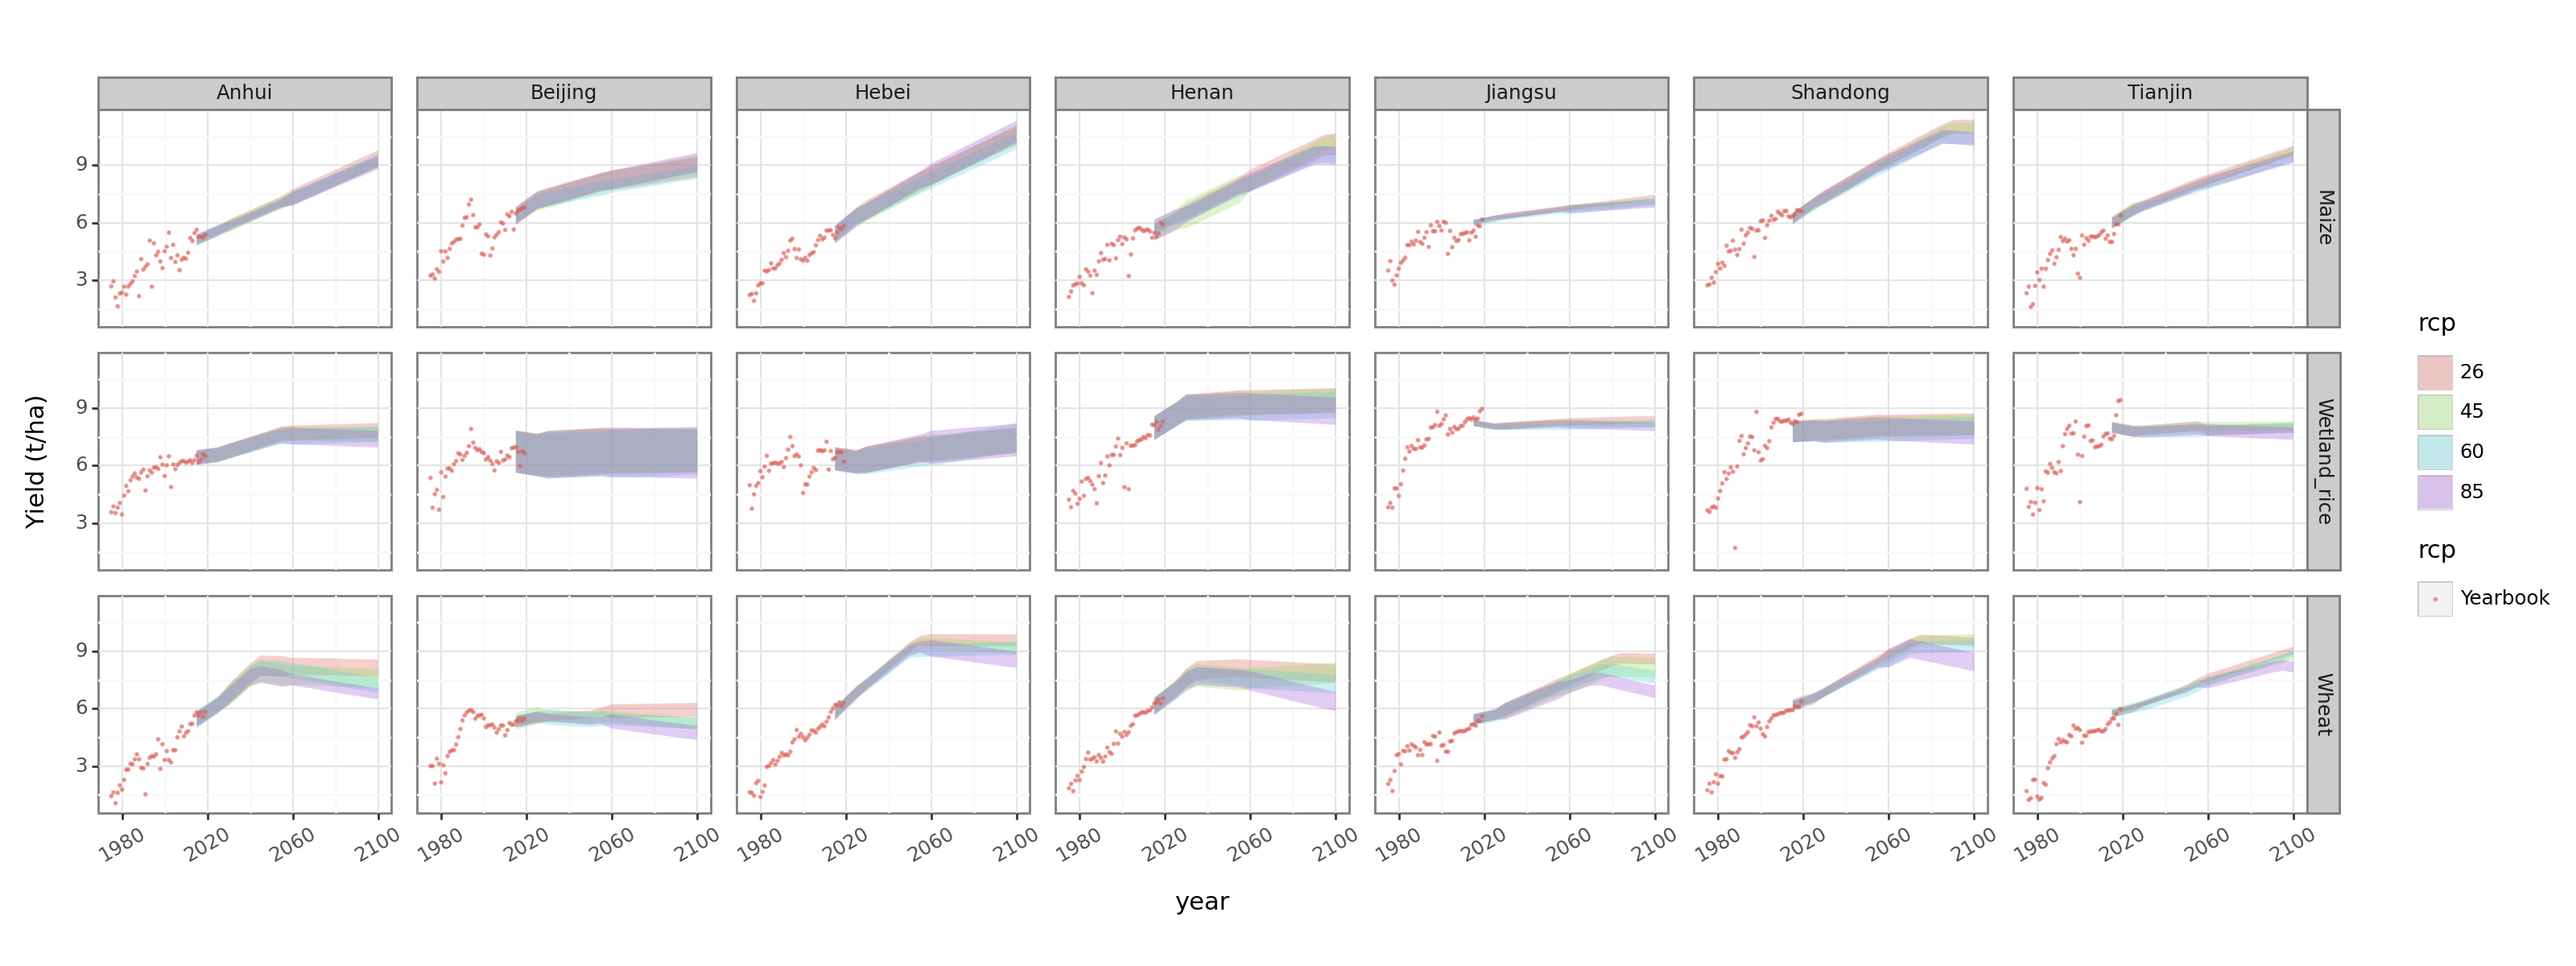

<Figure Size: (1600 x 600)>

In [48]:
# plot the trend of yearbook_yield_subtract_climate_impact
plotnine.options.figure_size = (16, 6)
plotnine.options.dpi = 100

(ggplot() +
 geom_ribbon(Scenario_BAU_yield_img_area_weighted_mean_df, aes(x='year',ymax='top',ymin='bot',fill='rcp'),alpha=0.3) +
 geom_point(crop_yield_history_1975_2020, aes('year','Mean Production',color='rcp'),alpha=0.5,size=0.2) +
 facet_grid('crop~Province') +
 theme_bw() + 
 theme(axis_text_x=element_text(rotation=30)) +
 scale_x_continuous(breaks=range(1980,2101,40)) +
 ylab('Yield (t/ha)')
)

### Scenario-2: Crop yield advancement plateaued in 2050

In [49]:
# set the year when crop yield plateaued
plateau_year = 2050

In [50]:
# compute the slope_increase of the crop yield in each year
linear_slope = yearbook_regression_parameter_df_1990 >> select(['crop','Province','linear_fit_a'])
linear_slope['slope_step'] = linear_slope['linear_fit_a'] / (plateau_year - 2010)
linear_slope['year'] = [list(range(2011,plateau_year + 1))] * len(linear_slope)
linear_slope = linear_slope.explode('year',ignore_index=True)
linear_slope['slope_to_plateau'] = linear_slope.apply(lambda x:x['linear_fit_a'] - (x['year'] - 2010) * x['slope_step'],1)
linear_slope['step_to_plateau'] = linear_slope.groupby(['crop','Province'])['slope_to_plateau'].cumsum()
linear_slope = linear_slope >> drop(['linear_fit_a','slope_step','slope_to_plateau'])

In [51]:
# create the delta img for each province
delta_mosaics = {}
for idx,df in linear_slope.groupby(['crop','year']):
  province_delta_dict = zip(df['Province'],df['step_to_plateau'])

  shps = []
  for province,val in province_delta_dict:
    shp = NCP_provinces.filterMetadata('EN_Name','equals',province).first()
    shp = shp.set('Name',province,'delta',val)
    shps.append(shp)

  fe_col = ee.FeatureCollection(shps)

  delta_mosaics[idx] = [ee.Image(0).toFloat().paint(featureCollection = fe_col,color='delta')]

# get the mosaiced imgs
delta_mosiac_img = pd.DataFrame(delta_mosaics).T.reset_index()
delta_mosiac_img.columns = ['crop','year','delta_img']

In [52]:
# merge GAEZ_actual_yield, add the delta_img to it
GAEZ_actual_link_slope_to_plateau_2010_2050 = GAEZ_actual_yield_propogated.merge(delta_mosiac_img)
GAEZ_actual_link_slope_to_plateau_2010_2050['img_future'] = GAEZ_actual_link_slope_to_plateau_2010_2050.apply(lambda row:row['propogated_yield']\
                                                                 .add(row['delta_img']),1)

# get the rows of 2055-2100, which are the same to img-2050
GAEZ_actual_link_slope_to_plateau_2055_2100 = GAEZ_actual_link_slope_to_plateau_2010_2050 >> mask(X.year == 2050)
GAEZ_actual_link_slope_to_plateau_2055_2100['year'] = [list(range(2055,2101,5))] * len(GAEZ_actual_link_slope_to_plateau_2055_2100)
GAEZ_actual_link_slope_to_plateau_2055_2100 = GAEZ_actual_link_slope_to_plateau_2055_2100.explode('year')

# concat to get the full df
Scanario_plateaued = pd.concat([GAEZ_actual_link_slope_to_plateau_2010_2050,GAEZ_actual_link_slope_to_plateau_2055_2100])
Scanario_plateaued = Scanario_plateaued >> drop(['delta_img','propogated_yield'])
Scanario_plateaued.to_pickle('./result_csv/Scanario_plateaued.pkl')

In [53]:
# 1) first get area_weighted mean attainable yield (t/ha)
Scenario_plateaued_weighted_mean = compute_area_weighted_mean(Scanario_plateaued)

# 2) then get mean attainable yield (t/ha) in each province
Scenario_plateaued_weighted_mean_df = parallelize_dataframe(Scenario_plateaued_weighted_mean,compute_yield_each_province,50)
Scenario_plateaued_weighted_mean_df['rcp'] = Scenario_plateaued_weighted_mean_df['rcp'].astype('category')
Scenario_plateaued_weighted_mean_df.to_csv('./result_csv/Scanario_plateaued_weighted_mean_df.csv',index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

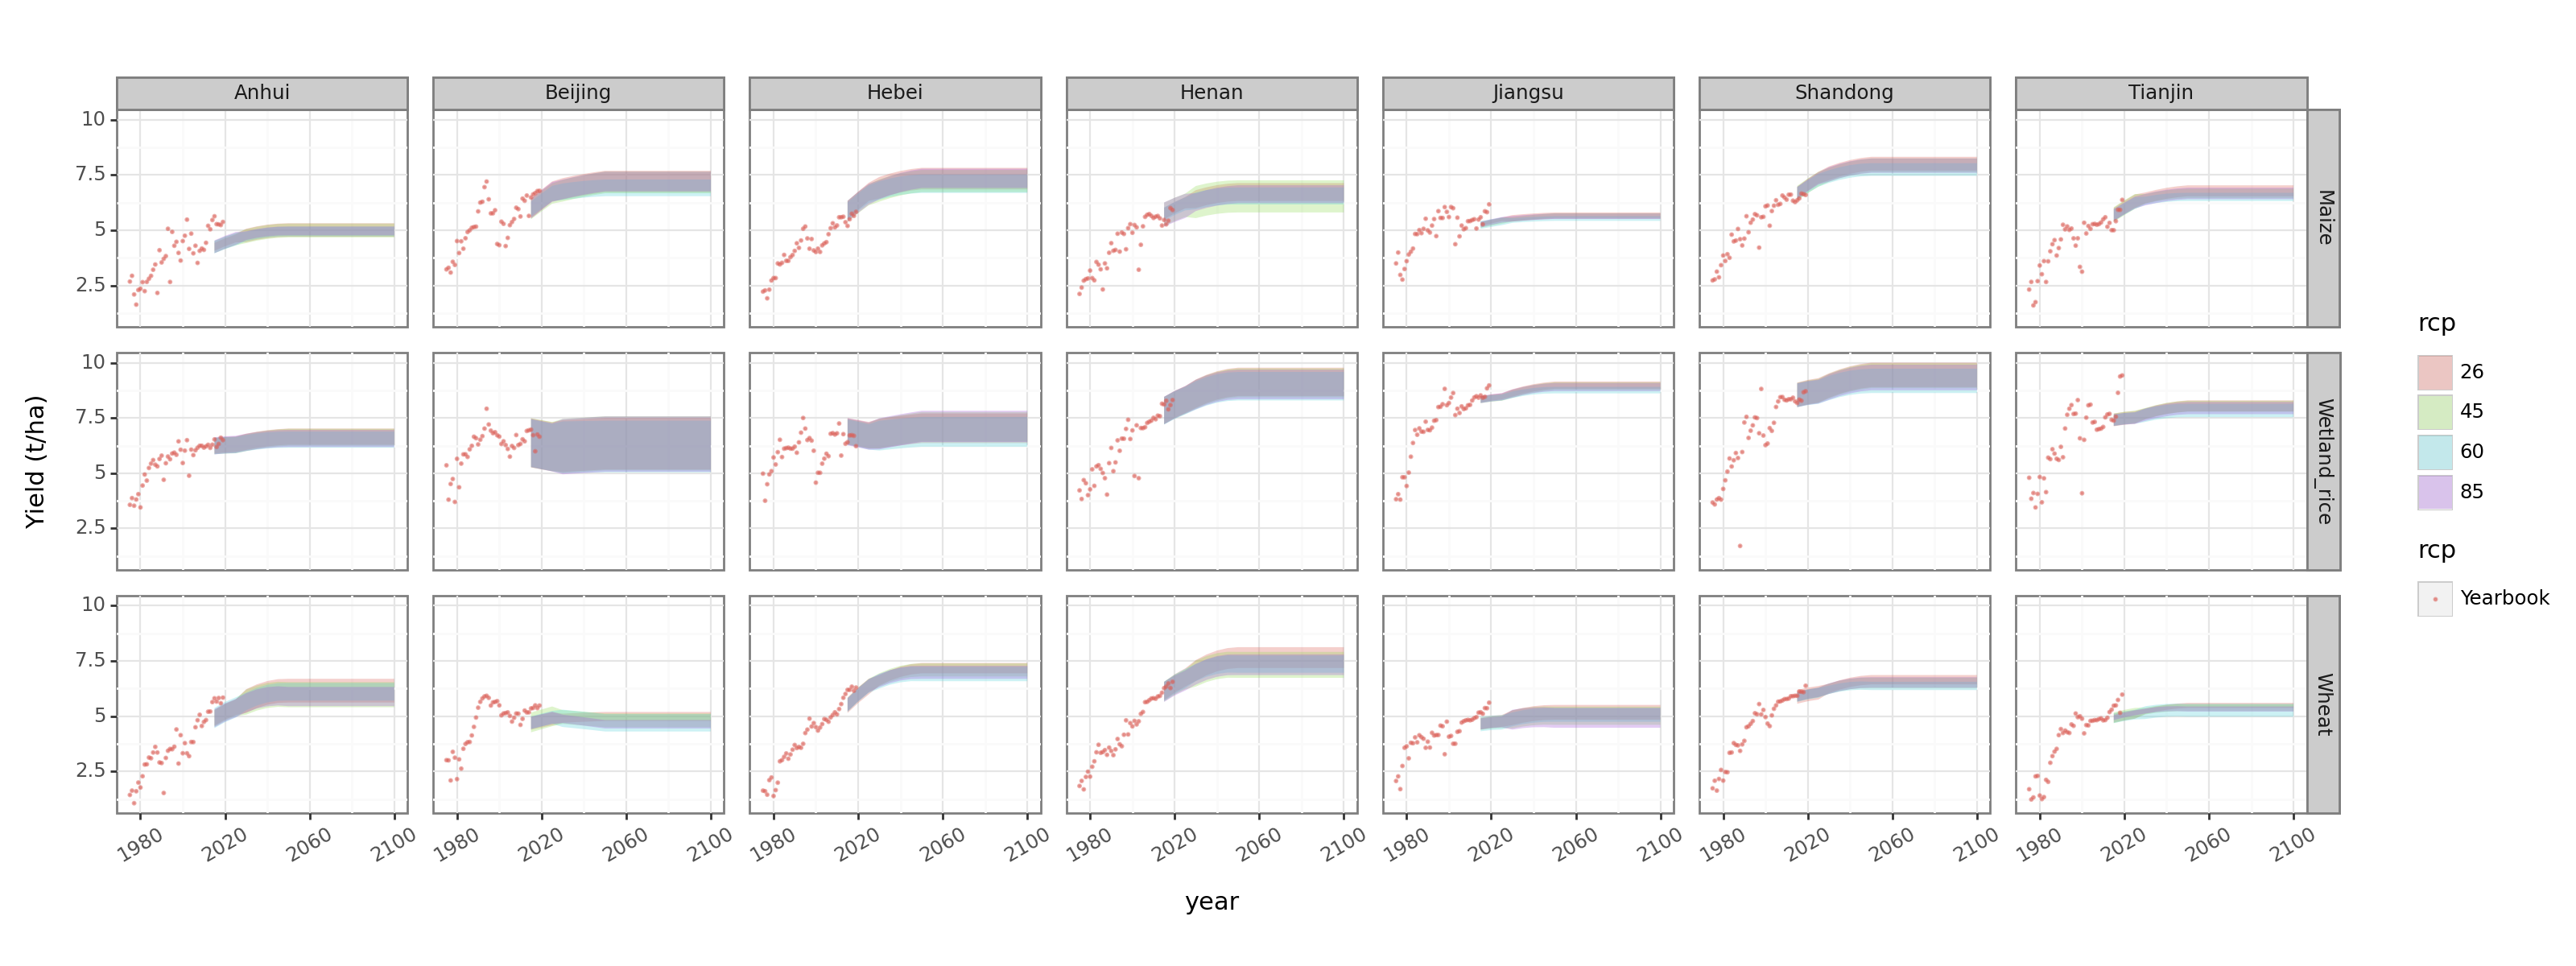

<Figure Size: (1600 x 600)>

In [54]:
# plot the trend of yearbook_yield_subtract_climate_impact
plotnine.options.figure_size = (16, 6)
plotnine.options.dpi = 100

(ggplot() +
#  geom_line(GAEZ_actual_link_slope_to_plateau_weighted_mean_df, aes(x='year',y='Mean Production',color='rcp'),alpha=0.3) +
 geom_ribbon(Scenario_plateaued_weighted_mean_df, aes(x='year',ymax='top',ymin='bot',fill='rcp'),alpha=0.3) +
 geom_point(crop_yield_history_1975_2020, aes('year','Mean Production',color='rcp'),alpha=0.5,size=0.2) +
 facet_grid('crop~Province') +
 theme_bw() + 
 theme(axis_text_x=element_text(rotation=30)) +
 scale_x_continuous(breaks=range(1980,2101,40)) +
 ylab('Yield (t/ha)')
)